# Notebook for drawing nice pictures for posts or presentations

In this notebook, we reproduce nice plottings to be used in linkedin posts and presentations.
In particular, the following images can be reproduced:
- Image of the network and the population obtained in the gadm shapes 

## Parameters and imports
### Paths

In [1]:
# Paths of build shapes
scenario_name = ""  # scenario name, default value is "" for tutorial or default configuration
                    # value shall be non null if a scenario name is specified under the "run" tag in the config file

scenario_subpath = scenario_name + "/" if scenario_name else ""
# path of the country shapes
path_country_shapes = "pypsa-earth/resources/" + scenario_subpath + "shapes/country_shapes.geojson"
# path of the off shore shapes
path_off_shore_shapes = "pypsa-earth/resources/" + scenario_subpath + "shapes/offshore_shapes.geojson"
# path of the gadm shapes
path_gadm_shapes = "pypsa-earth/resources/" + scenario_subpath + "shapes/gadm_shapes.geojson"

# Path of the OSM data
# raw OSM substation data
path_raw_substations = "pypsa-earth/resources/" + scenario_subpath + "osm/raw/all_raw_substations.geojson"
# raw OSM lines data
path_raw_lines = "pypsa-earth/resources/" + scenario_subpath + "osm/raw/all_raw_lines.geojson"

# network paths
path_cluster_network = "pypsa-earth/networks/" + scenario_subpath + "elec_s_6.nc"
# solve network output
solved_network_path = "pypsa-earth/results/" + scenario_subpath + "networks/elec_s_6_ec_lcopt_Co2L-4H.nc"

# Images setups
max_width_image = 30
max_height_image = 30
dpi = 300


### Python imports

In [2]:
import xarray as xr
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import requests
import pypsa
import shutil
from rasterio.plot import show
from shapely.wkt import loads
from shapely.geometry import Point
from shapely.geometry import LineString

# change current directory to parent folder
import os
import sys

if not os.path.isdir("pypsa-earth"):
    os.chdir("../..")
sys.path.append(os.getcwd()+"/pypsa-earth/scripts")

from _helpers import create_country_list

### Auxiliary functions

In [3]:
def calculate_width_height_image(
    width_image, height_image, max_width=max_width_image, max_height=max_height_image
):
    """
    Function to identify the width and height of an image to plot
    while keeping the proportions of the image
    """
    if width_image / height_image >= max_width / max_height:
        # image width is the limiting factor
        return (max_width, max_width / width_image * height_image)
    else:
        # image height is the limiting factor
        return (max_height / height_image * width_image, max_height)

### File imports

In [4]:
# gadm file imports
countries = gpd.read_file(path_country_shapes)
off_shore = gpd.read_file(path_off_shore_shapes)
gadm = gpd.read_file(path_gadm_shapes)

# OSM data imports
df_substations_osm_raw = gpd.read_file(path_raw_substations)
df_lines_osm_raw = gpd.read_file(path_raw_lines)

# network imports
# cluster network
n_c = pypsa.Network(path_cluster_network)
# solved network
n_solve = pypsa.Network(solved_network_path)

INFO:pypsa.io:Imported network elec_s_6.nc has buses, carriers, generators, lines, loads, storage_units
INFO:pypsa.io:Imported network elec_s_6_ec_lcopt_Co2L-4H.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


## Continent and raw OSM data

### Plot for the entire area downloaded

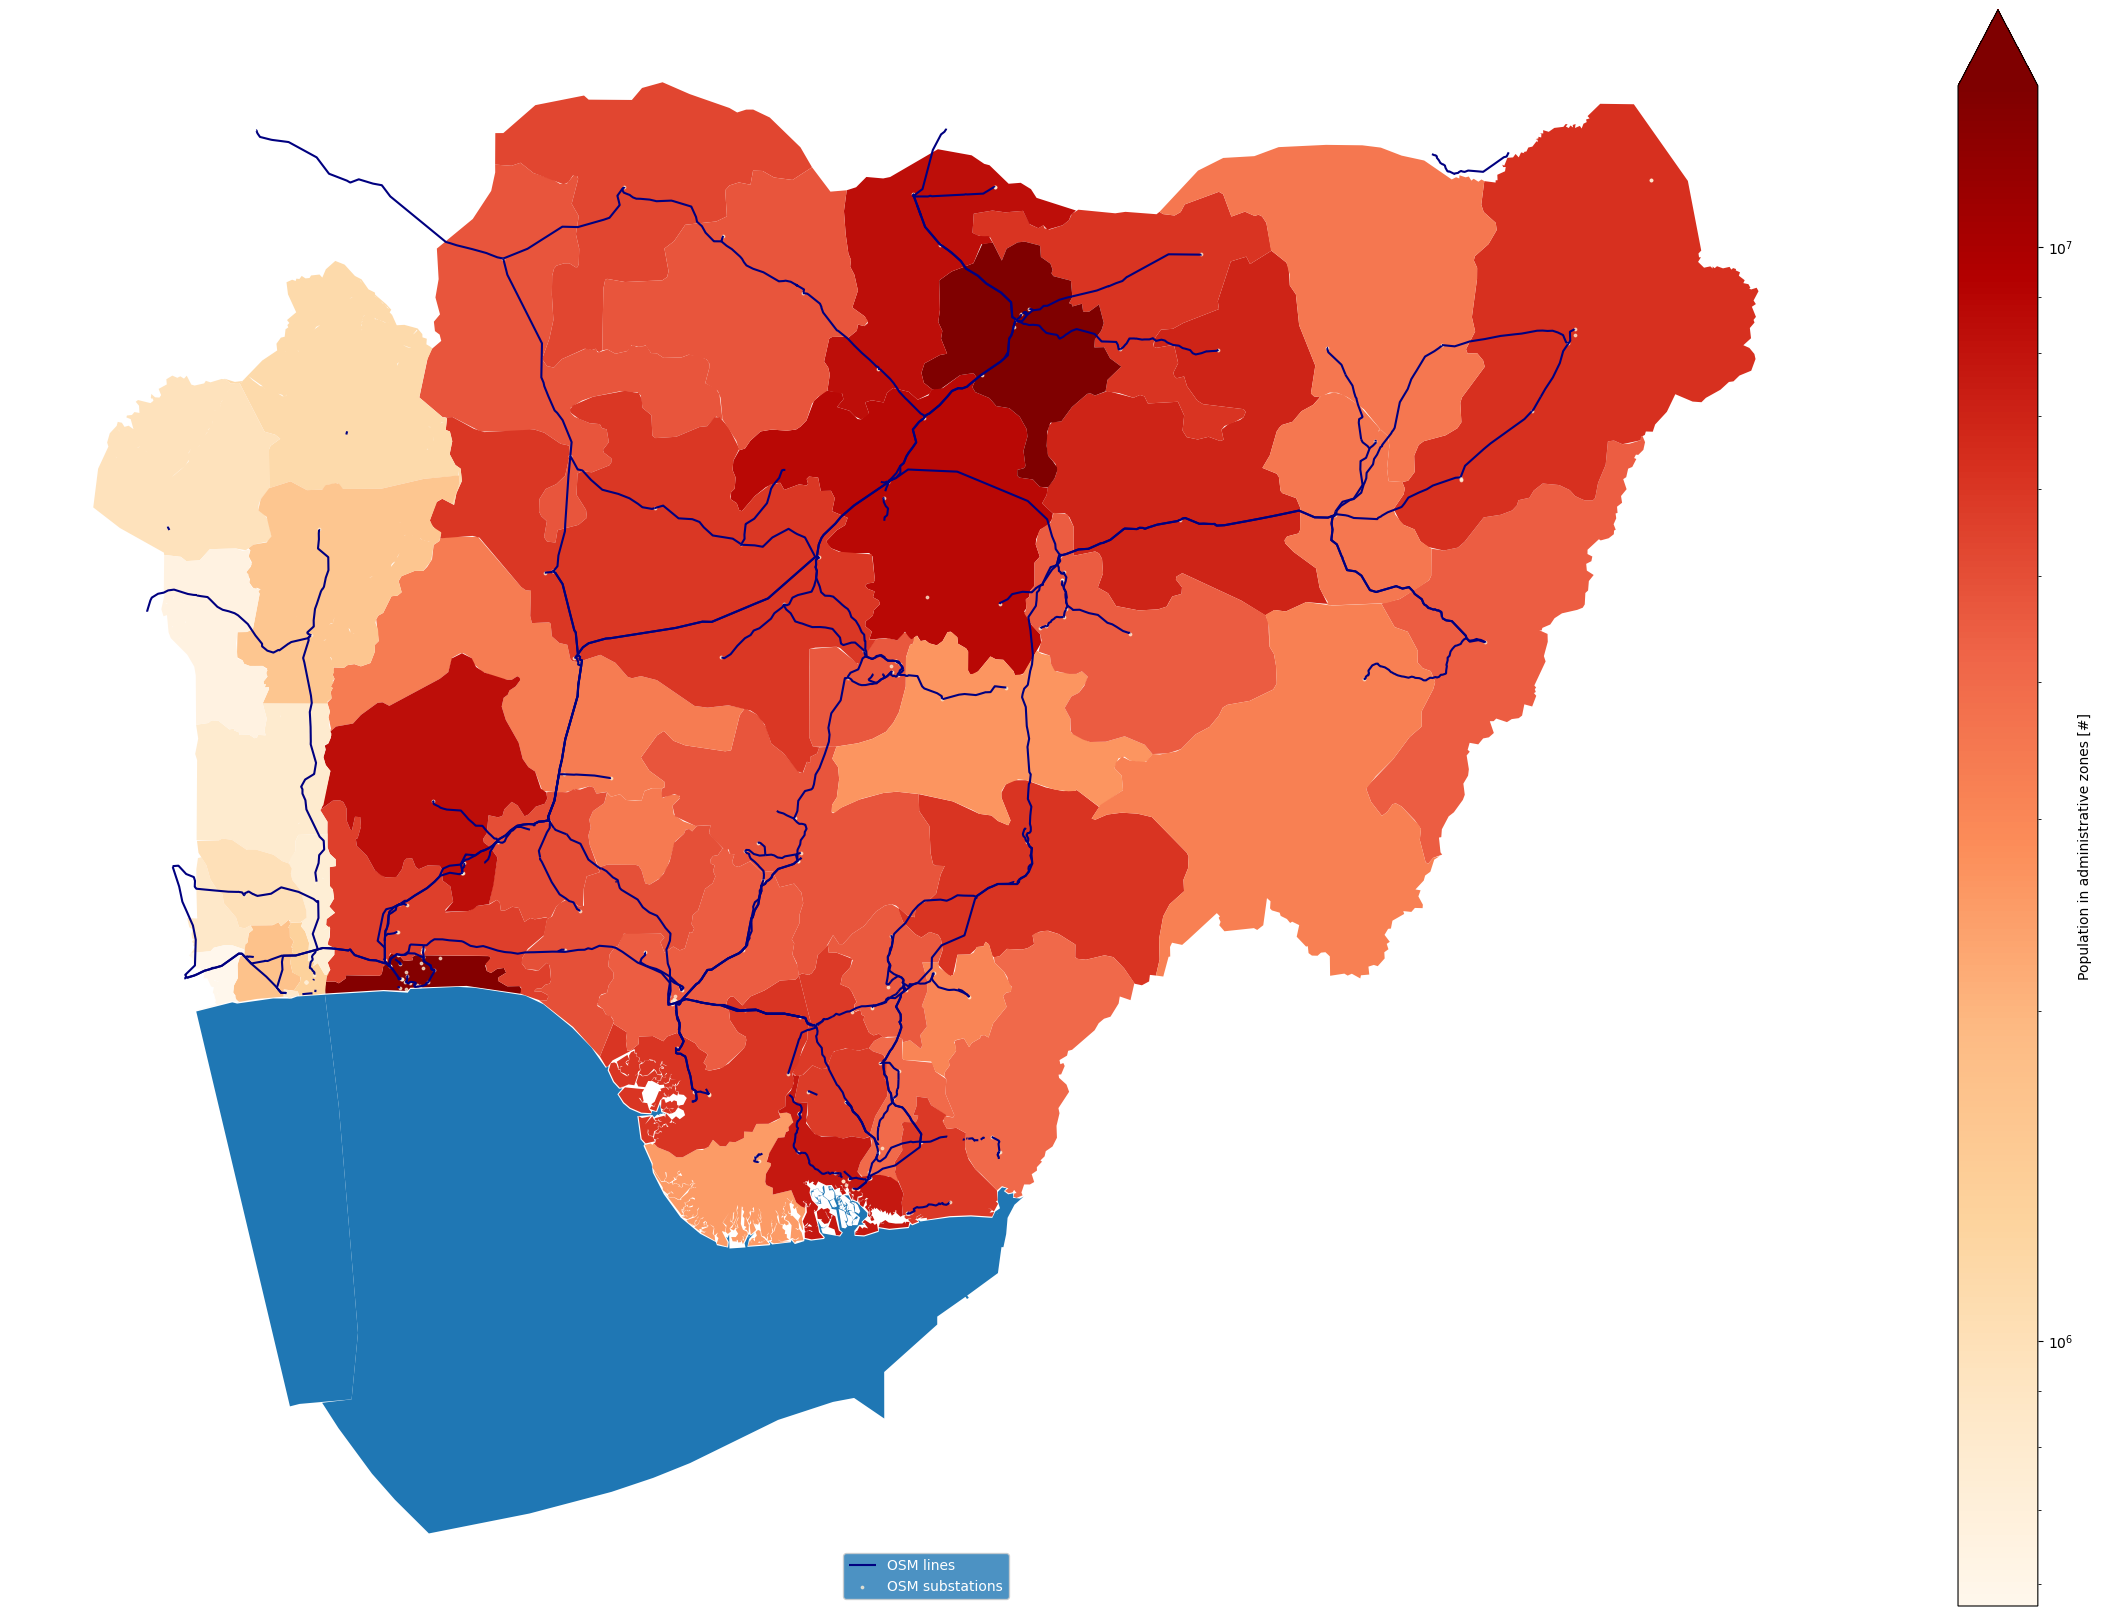

In [5]:
total_bounds_countries = countries.total_bounds
delta_bounds_xy = (
    total_bounds_countries[2] - total_bounds_countries[0],  # maxx - minx
    total_bounds_countries[3] - total_bounds_countries[1],
)  # maxy - miny

size_image = calculate_width_height_image(*delta_bounds_xy)

ax2 = gadm.plot(
    column="pop",
    cmap="OrRd",
    figsize=size_image,
    legend=True,
    label=None,
    norm=matplotlib.colors.LogNorm(
        vmin=gadm["pop"].min() + 1, vmax=gadm["pop"].max(), clip=True
    ),
    legend_kwds={"extend": "max", "label": "Population in administrative zones [#]"},
)  # column="pop",
off_shore.plot(ax=ax2, label=None)  # "offshore")
df_lines_osm_raw.plot(ax=ax2, color="navy", label="OSM lines")
df_substations_osm_raw.plot(
    ax=ax2, color="papayawhip", label="OSM substations", alpha=0.7, markersize=3
)

legend = plt.legend(
    frameon=1, loc="lower center", labelcolor="white", facecolor="tab:blue"
)

plt.axis("off")
plt.savefig("continent_image.png", dpi=dpi, bbox_inches="tight")

### Plot for a subregion specified by a string as in "countries" config

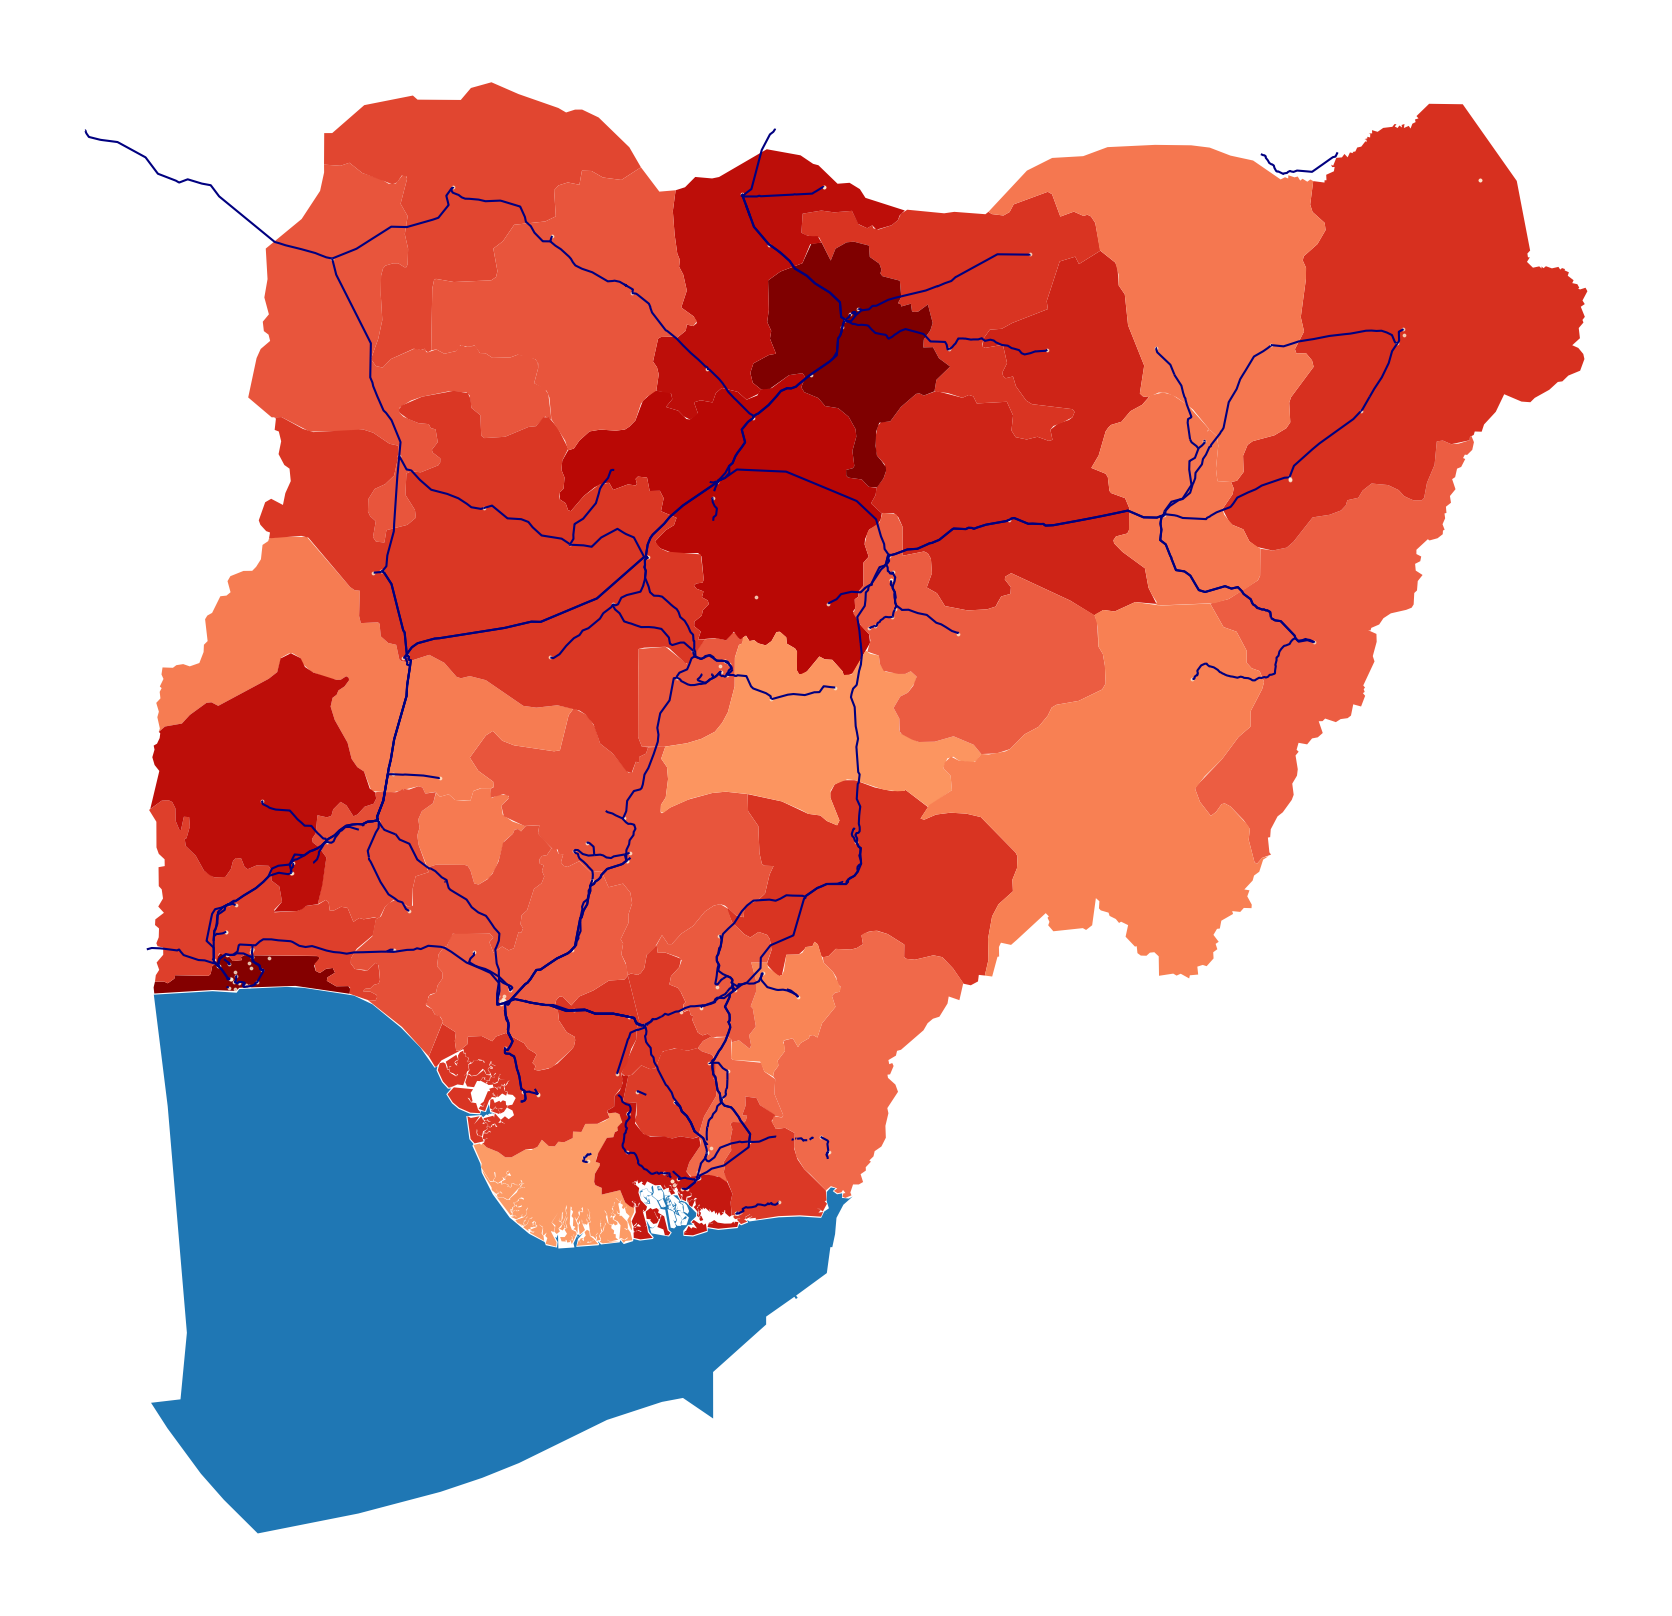

In [6]:
region = ["NG"]

list_countries = create_country_list(region)

ax2 = gadm[gadm.country.isin(list_countries)].plot(
    column="pop",
    cmap="OrRd",
    figsize=size_image,
    legend=None,
    norm=matplotlib.colors.LogNorm(
        vmin=gadm["pop"].min() + 1, vmax=gadm["pop"].max(), clip=True
    ),
)  # column="pop",
off_shore[off_shore.name.isin(list_countries)].plot(ax=ax2, label="offshore")
df_lines_osm_raw[df_lines_osm_raw.Country.isin(list_countries)].plot(
    ax=ax2, color="navy"
)
df_substations_osm_raw[df_substations_osm_raw.Country.isin(list_countries)].plot(
    ax=ax2, color="papayawhip", alpha=0.7, markersize=3
)

plt.axis("off")
plt.savefig("region_image.png", dpi=dpi)

### Plot country shape and OSM data

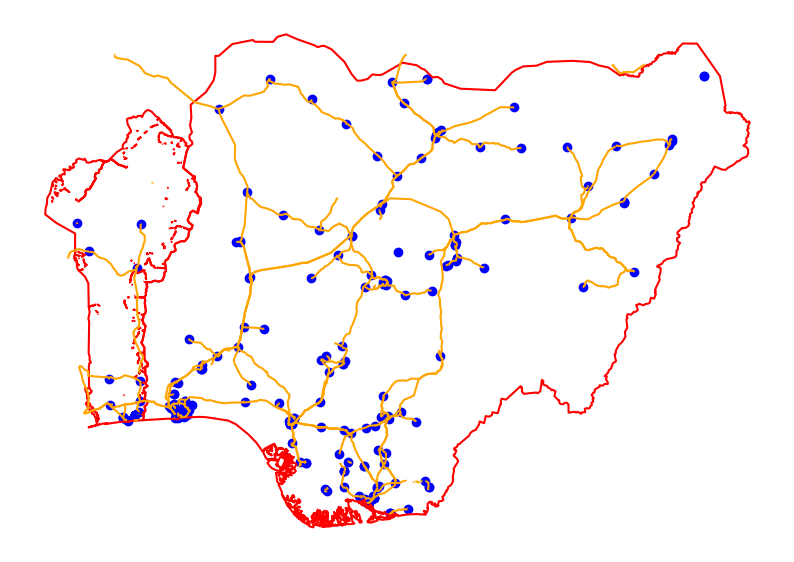

In [7]:
ax = countries.boundary.plot(figsize=(10, 10), color="red")
# off_shore.plot(ax=ax)
df_substations_osm_raw.plot(ax=ax, color="blue")
df_lines_osm_raw.plot(ax=ax, color="orange")
plt.axis("off")
plt.savefig("border_osm_total.png", dpi=dpi)

### Plot country shape and OSM data for the region

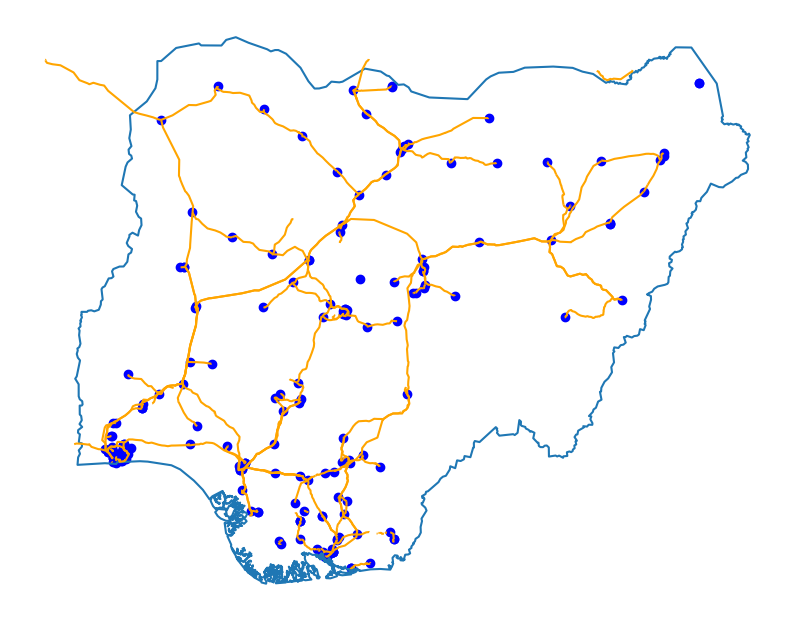

In [8]:
ax = countries[countries.name.isin(list_countries)].boundary.plot(figsize=(10, 10))
# off_shore.plot(ax=ax)
df_substations_osm_raw[df_substations_osm_raw.Country.isin(list_countries)].plot(
    ax=ax, color="blue"
)
df_lines_osm_raw[df_lines_osm_raw.Country.isin(list_countries)].plot(
    ax=ax, color="orange"
)
plt.axis("off")
plt.savefig("border_osm_region.png", dpi=dpi)

### Plot country shape and OSM data for a specific country

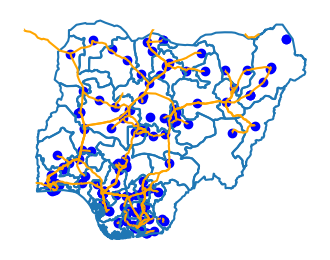

In [9]:
specific_country = ["NG"]

ax = gadm[gadm.country.isin(specific_country)].boundary.plot(figsize=(4, 4))
# off_shore.plot(ax=ax)
df_substations_osm_raw[df_substations_osm_raw.Country.isin(specific_country)].plot(
    ax=ax, color="blue"
)
df_lines_osm_raw[df_lines_osm_raw.Country.isin(specific_country)].plot(
    ax=ax, color="orange"
)
plt.axis("off")
plt.savefig("border_osm_specificregion.png", dpi=dpi)

## Cluster network features

### Plot cluster network

/home/davidef/miniconda3/envs/pypsa-earth/lib/python3.8/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


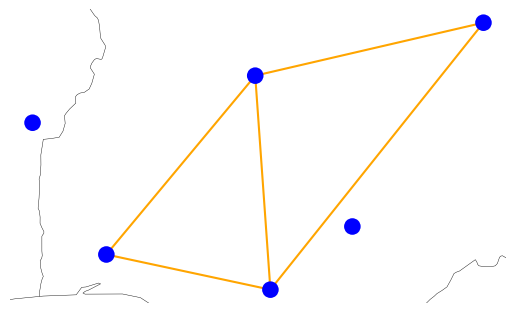

In [10]:
# buses dataframe
buses_c = n_c.buses
buses_c["geometry"] = gpd.points_from_xy(buses_c.x, buses_c.y)
buses_c = gpd.GeoDataFrame(buses_c, crs="epsg:4326")

# lines dataframe
lines_c = n_c.lines
lines_c["geometry"] = lines_c.apply(
    lambda x: LineString(
        [buses_c.loc[x["bus0"], "geometry"], buses_c.loc[x["bus1"], "geometry"]]
    ),
    axis=1,
)
lines_c = gpd.GeoDataFrame(lines_c, crs="epsg:4326")

n_c.plot(bus_colors="blue", line_colors="orange")

plt.savefig("cluster_network.png", dpi=dpi)

## Data report on installed generation

In [11]:
# filter only generators
generators = n_solve.generators

# obtain installed generation by carrier
generators.groupby(by="carrier")["p_nom_opt"].sum()

carrier
CCGT      1.472099e+03
OCGT      6.021930e+03
load      6.000000e+09
oil       2.187625e+03
onwind    9.035268e+02
solar     1.476527e+04
Name: p_nom_opt, dtype: float64

In [12]:
n_solve.links.groupby(by="carrier")["p_nom_opt"].sum()

carrier
H2 electrolysis       16.8629
H2 fuel cell          45.8671
battery charger        0.0000
battery discharger     0.0000
Name: p_nom_opt, dtype: float64

In [13]:
n_solve.storage_units.groupby(by="carrier")["p_nom_opt"].sum() / 1000

carrier
hydro    1.905414
Name: p_nom_opt, dtype: float64

In [14]:
n_solve.storage_units

,efficiency_dispatch,bus,cyclic_state_of_charge,p_nom,efficiency_store,carrier,p_min_pu,max_hours,marginal_cost,p_nom_opt,...,sign,capital_cost,build_year,lifetime,state_of_charge_initial,state_of_charge_initial_per_period,state_of_charge_set,cyclic_state_of_charge_per_period,standing_loss,inflow
StorageUnit,,,,,,,,,,,,,,,,,,,,,
NG1 2 hydro,0.9,NG1 2,True,1905.414013,0.0,hydro,0.0,6.0,0.010848,1905.414013,...,1.0,0.0,0,inf,0.0,False,NaN,True,0.0,0.0
